In [1]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!

import sequence
import train_TFmodel
import eval_TFmodel
import seq_only_gen

import ucscgenome
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 

Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


In [2]:
# get the generator
gen = seq_only_gen.TFGenerator('/home/kal/TF_models/seq_only/ctcfgen.hdf5')
g = gen.pair_gen(mode='val')

In [3]:
# get the model
sig = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/20170919_sigmoid_model/')
reg = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_regression/20180125_174348_CTCF/')
pwm = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/pwm_frozen/')

Loading model without Bias layer


In [4]:
# get the genome
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

2481


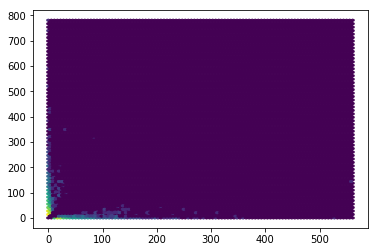

2434


In [5]:
# get the snvs
genomes_path = '/home/kal/TF_models/data/SNVs/1000genomes_SNVs/1000genomes_all_SNVs_motifcount.bed'
#genomes_pth = '/home/kal/TF_models/data/SNVs/1000genomes_SNVs/1000genomes_motif_SNVs.bed'
snvs = pd.read_table(genomes_path)
snvs.columns = 'chr position end variantID refAllele A C T G motifCount'.split()
ctcf_snvs = snvs[snvs.variantID.apply(lambda x: 'CTCF' in x)].copy()

# change the 1000 genomes data to be the same format
order = {'A':0, 'C':1, 'G':2, 'T':3}
rorder = ['A', 'C', 'G', 'T']
for index, row in ctcf_snvs.iterrows():
    counts = [row['A'], row['C'], row['G'], row['T']]
    refCount = counts[order[row['refAllele']]]
    counts[order[row['refAllele']]] = 0
    altCount = max(counts)
    altAllele = rorder[counts.index(altCount)]
    # set this in the snvs
    ctcf_snvs.set_value(index, 'refCount', refCount)
    ctcf_snvs.set_value(index, 'altCount', altCount)
    ctcf_snvs.set_value(index, 'altAllele', altAllele)
    
# filter the snvs for high read counts
print(len(ctcf_snvs))
ctcf_snvs = ctcf_snvs[ctcf_snvs['refCount'] + ctcf_snvs['altCount'] > 10]
#ctcf_snvs = ctcf_snvs[abs(ctcf_snvs['refCount'] - ctcf_snvs['altCount']) > 30]
plt.hexbin(ctcf_snvs.refCount, ctcf_snvs.altCount, bins='log')
plt.show()
print(len(ctcf_snvs))

In [6]:
# get predicitons
prefpreds, paltpreds = pwm.predict_snv(ctcf_snvs, genome)
#filter for strong motifs
ctcf_snvs = ctcf_snvs[[(pref > 1250) or (palt > 1250) for pref, palt in zip(prefpreds, paltpreds)]]
refpreds, altpreds = reg.predict_snv(ctcf_snvs, genome)
prefpreds, paltpreds = pwm.predict_snv(ctcf_snvs, genome)
print(len(ctcf_snvs))

224


In [7]:
# get differences
allelic_ratio = [int(alt)/(int(alt) + int(ref)) for alt, ref in zip(ctcf_snvs.altCount, ctcf_snvs.refCount)]
diffs = altpreds - refpreds
pdiffs = paltpreds - prefpreds
ratios = [alt/(ref+alt) for ref, alt in zip(refpreds, altpreds)]
pratios = [alt/(ref+alt) for ref, alt in zip(prefpreds, paltpreds)]

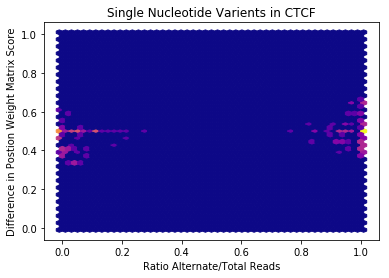

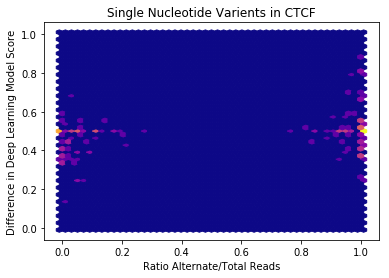

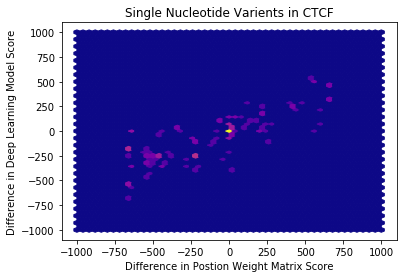

In [8]:
plt.hexbin(allelic_ratio, pratios, gridsize=50, bins='log', cmap='plasma', extent=(-.01, 1.01, -.01, 1.01))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Postion Weight Matrix Score')
plt.show()

plt.hexbin(allelic_ratio, ratios, gridsize=50, bins='log', cmap='plasma', extent=(-.01, 1.01, -.01, 1.01))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

plt.hexbin(pdiffs, diffs, gridsize=50, bins='log', cmap='plasma', extent=(-1000, 1000, -1000, 1000))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Difference in Postion Weight Matrix Score')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

1355262
1354812


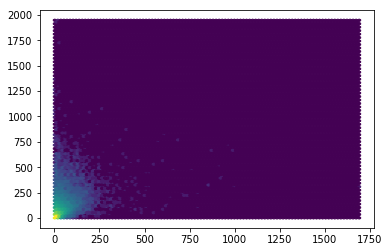

59073


In [9]:
# annotate the thouis dataset
thouis_path = '/home/kal/TF_models/data/snvs/all_snvs_merged.bed'
snvs = pd.read_table(thouis_path)
snvs.columns = 'chr start end refAllele altAllele refCount altCount'.split()
snvs['position'] = snvs.start - 1

# filter the snvs for only legal chrs
snvs = snvs[snvs['chr']!='contig']
snvs['position'] = [int(position) for position in snvs.position]
snvs = snvs[snvs['refAllele'].isin(['A', 'C', 'T', 'G'])]
snvs = snvs[snvs['altAllele'].isin(['A', 'C', 'T', 'G'])]

# filter the snvs for high read counts
snvs = snvs[snvs['refCount'] + snvs['altCount'] > 10]
snvs = snvs[(snvs['refCount'] > 1) & (snvs['altCount'] > 1)]
plt.hexbin(snvs.refCount, snvs.altCount, bins='log')
plt.show()

In [10]:
# get predicitons
all_refpreds, all_altpreds = reg.predict_snv(snvs, genome)
all_prefpreds, all_paltpreds = pwm.predict_snv(snvs, genome)

Sequence at chrM 16520 is too short!
Sequence at chrM 16520 is too short!
Sequence at chrM 16520 is too short!
Sequence at chrM 16520 is too short!


In [11]:
# get differences
allelic_ratio = [int(alt)/(int(alt) + int(ref)) for alt, ref in zip(snvs.altCount, snvs.refCount)]
diffs = all_altpreds - all_refpreds
pdiffs = all_paltpreds - all_prefpreds
ratios = [alt/(ref+alt) for ref, alt in zip(all_refpreds, all_altpreds)]
pratios = [alt/(ref+alt) for ref, alt in zip(all_prefpreds, all_paltpreds)]

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in float_scalars


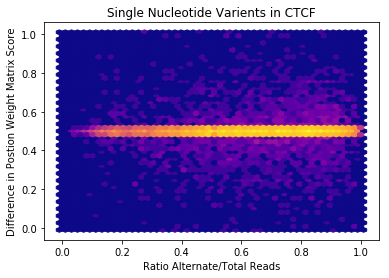

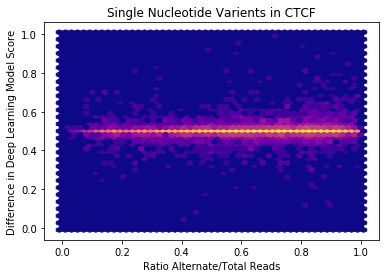

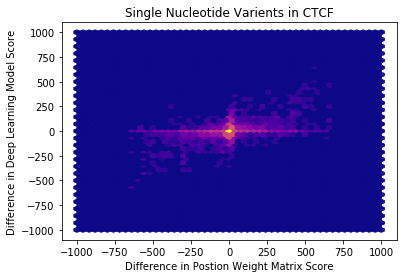

In [12]:
plt.hexbin(allelic_ratio, pratios, gridsize=50, bins='log', cmap='plasma', extent=(-.01, 1.01,-.01, 1.01))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Postion Weight Matrix Score')
plt.show()

plt.hexbin(allelic_ratio, ratios, gridsize=50, bins='log', cmap='plasma', extent=(-.01, 1.01, -.01, 1.01))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

plt.hexbin(pdiffs, diffs, gridsize=50, bins='log', cmap='plasma', extent=(-1000, 1000, -1000, 1000))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Difference in Postion Weight Matrix Score')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

In [13]:
# get only strong pwm signals
strong_filter = [((pref > 1500) or (palt > 1500)) for pref, palt in zip(all_prefpreds, all_paltpreds)]
refpreds = all_refpreds[strong_filter]
altpreds = all_altpreds[strong_filter]
prefpreds = all_prefpreds[strong_filter]
paltpreds = all_paltpreds[strong_filter]

# get differences
allelic_ratio = [int(alt)/(int(alt) + int(ref)) for alt, ref in zip(snvs.altCount[strong_filter], snvs.refCount[strong_filter])]
diffs = altpreds - refpreds
pdiffs = paltpreds - prefpreds
ratios = [alt/(ref+alt) for ref, alt in zip(refpreds, altpreds)]
pratios = [alt/(ref+alt) for ref, alt in zip(prefpreds, paltpreds)]

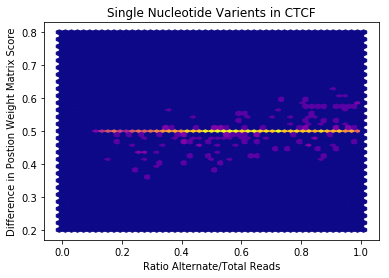

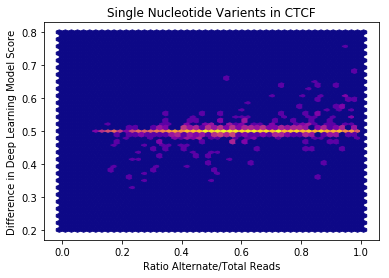

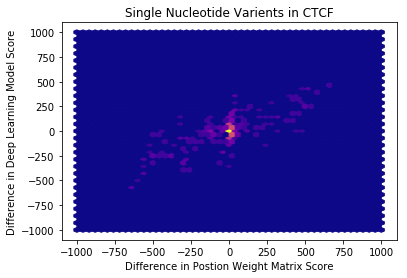

In [14]:
plt.hexbin(allelic_ratio, pratios, gridsize=50, bins='log', cmap='plasma', extent=(-.01, 1.01, .2, .8))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Postion Weight Matrix Score')
plt.show()

plt.hexbin(allelic_ratio, ratios, gridsize=50, bins='log', cmap='plasma', extent=(-.01, 1.01, .2, .8))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

plt.hexbin(pdiffs, diffs, gridsize=50, bins='log', cmap='plasma', extent=(-1000, 1000, -1000, 1000))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Difference in Postion Weight Matrix Score')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

In [15]:
# get only strong machine learning signals
strong_filter = [((ref > 900) or (alt > 900)) and (abs(alt-ref) > 1) for ref, alt in zip(all_refpreds, all_altpreds)]
refpreds = all_refpreds[strong_filter]
altpreds = all_altpreds[strong_filter]
prefpreds = all_prefpreds[strong_filter]
paltpreds = all_paltpreds[strong_filter]

# get differences
allelic_ratio = [int(alt)/(int(alt) + int(ref)) for alt, ref in zip(snvs.altCount[strong_filter], snvs.refCount[strong_filter])]
diffs = altpreds - refpreds
pdiffs = paltpreds - prefpreds
ratios = [alt/(ref+alt) for ref, alt in zip(refpreds, altpreds)]
pratios = [alt/(ref+alt) for ref, alt in zip(prefpreds, paltpreds)]

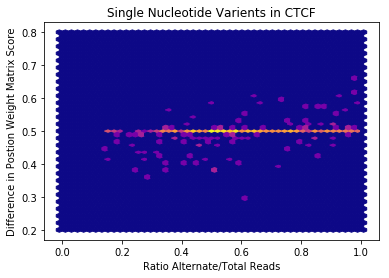

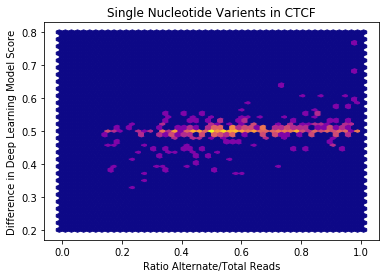

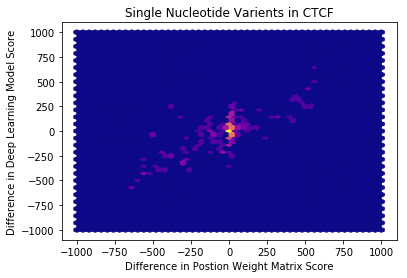

In [16]:
plt.hexbin(allelic_ratio, pratios, gridsize=50, bins='log', cmap='plasma', extent=(-.01, 1.01, .2, .8))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Postion Weight Matrix Score')
plt.show()

plt.hexbin(allelic_ratio, ratios, gridsize=50, bins='log', cmap='plasma', extent=(-.01, 1.01, .2, .8))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

plt.hexbin(pdiffs, diffs, gridsize=50, bins='log', cmap='plasma', extent=(-1000, 1000, -1000, 1000))
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Difference in Postion Weight Matrix Score')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

In [17]:
# plot some of the sequences the ml algorithm gets but the ml doesnt
strong_filter = [(abs(ml-.5) > .2) and (abs(pwm-.5)< .2) and ((ml<.5) == (alelle<.5)) for ml, pwm, allele in zip(ratios, pratios, allelic_ratio)]
intrigue = 

0
